In [1]:
import random
import matplotlib.pyplot as plt
from matplotlib import colors
import time
import numpy as np

### A simple Individual-based model
Individual-based models (IBMs) simulate biological systems as being composed of a finite number of individuals with each individual having a set of attributes. These attributes can be spatial location, morphological or physiological traits, bahavioral rules, ... and may be unique to a specific individual. This uniqueness in attributes allows for a certain level of individuality or heterogenity and consequently stochasticity and randomness which can not be achieved in other modelling approaches. Individuals can represent ants looking for food, birds forming a flock, trees in a forest, bacteria in a biofilm, cars in a traffic jam, people in a crowd, traders in the stockmarket and so on. You can find more biological examples at https://en.wikipedia.org/wiki/Agent-based_model_in_biology. IBMs' basic framework allows them to be as complicated or simple as you want them to be. However, IMBs quickly become rather computationally intensive since every individual has to be evaluated and simulated each timestep. Furthermore, in very complicated IBMs it can become difficult to pinpoint exactly what determines the outcome.

In practice, IBMs start with creating a number of individuals which programmatically are contained within a list (the population). Each timestep, the model iterates over this list and evaluates and, if needed, updates the characteristics of each individual. This iteration is then performed n-number of times afterwhich the model and its outcome can be evaluated.

In this notebook, we will build a simple IBM of growing cells. To do so, we will introduce a new programming concept, object-oriented programming with classes and objects. A class is a sort of blueprint from which objects are being created. To understand the power of classes, let's create one. Classes are created by the keyword class followed by an assigned name of the class using the class keyword:
```python
class <class_name>:
    <include characteristics or behaviors>
```

To give a class specific characteristics, we have to use the `__init__()` constructor. Within this constructor you can assign attributes or properties to the class.
```python
class <class_name>:
    def __init__(self,attribute):
        self.attribute=attribute
```
The 'self.' keyword indicates that this attribute is bound to this class and allows you to access the attribute easily.

Let's now create a class, named Individual, representing a cell with one attribute: growthrate.

In [2]:
class Individual:
    def __init__(self,growthrate): #__init__ is a constructor in which the variables assigned to the class itself are assigned
        self.growthrate=growthrate #self. keyword means that this refers to itself.
     

Using this class, we can now create a `Cell` with a growthrate of 0.5. Something created using a class is referred to as an object. Anything assigned to this object can be easily accessed. E.g. retrieving the growthrate of an object `Cell` created from the class `Individual` can be achieved by executing `Cell.growthrate`

In [3]:
Cell=Individual(growthrate=0.5) #Cell is an object created using a class
print(Cell.growthrate)

0.5


So we just created one single individual cell. Let's now create a population of cells with growthrate=0.1. To do this, we will first write a function `PopCreator` that contains a for loop to populate a list with all the created cells. This list is finally returned.

In [4]:
def PopCreator(Pop_size,g_rate):
    groupList=[]
    for j in range(0,Pop_size):
        groupList.append(Individual(growthrate=g_rate))
    return groupList

Now we can create population of 10 cells using this function and execute this list to see what's in it.

In [5]:
Pop=PopCreator(Pop_size=10,g_rate=0.1)
Pop #this returns the class name and the memory address (written in hexidecimal)


Oke, let's now simulate the growth of this population given their growthrate. But first we will add a behavior to our class, namely being able to reproduce. To do that, we can add a method to our class using the keyword `def`. This method is similar to a python function, however here it is intrinsically coupled to the object.

Let's consider growth rate to be the probability to reproduce then we can write a simple `birth` function that chooses between reproducing or not and the probability of each choice is given by the growthrate of the individual.

In [6]:
class Individual:
    def __init__(self,growthrate): #__init__ is a constructor in which the variables assigned to the class itself are assigned
        self.growthrate=growthrate #self. keyword means that this refers to itself.
     
    def birth(self):
        if random.choices([0,1], [1-self.growthrate ,self.growthrate])[0]==1:
            return Individual(growthrate=self.growthrate)
        else:
            return False
        

Let's now simulate growth of this population. To do so, we write a loop that iterates over the number of timepoints we want to simulate and each timestep we iterate over the population and run the birth function. Chance will then decide whether an individual reproduces or not. If so a new individual is added to the population. 

In [7]:
Pop=PopCreator(Pop_size=1,g_rate=0.1)

output_pop_simple=[] #list for storing the size of the pop at each timepoint
simulation_length=500
for t in range(simulation_length):
    new_pop=[]
    for indiv in Pop:
        new_pop.append(indiv)
        new_indiv = indiv.birth()
        if new_indiv == False:
            pass
        else:
            new_pop.append(new_indiv)

    output_pop_simple.append(len(new_pop))
    
    if len(new_pop)>=1000: #we will break the simulation at 1000 inidividuals since exponential growth is not limited by anything
        break
    Pop=new_pop
    

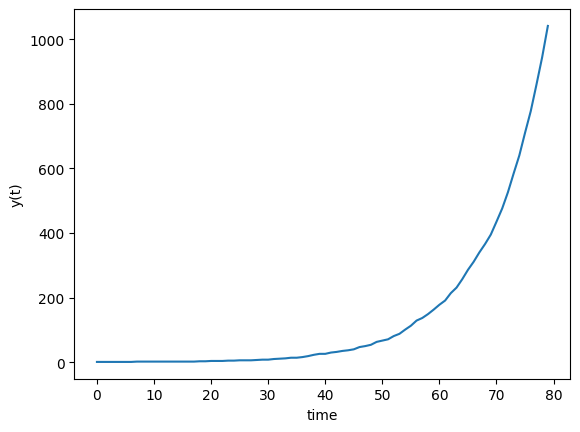

In [8]:
plt.plot(range(len(output_pop_simple)),output_pop_simple)
plt.xlabel('time')
plt.ylabel('y(t)')
plt.show()

### Adding a spatial component: Modelling bacterial growth on an agar plate
Let's add a spatial component to this simple IBM and simulate growth of colonies on an agar plate.

First we will create a n*m grid upon which we will simulate growth.

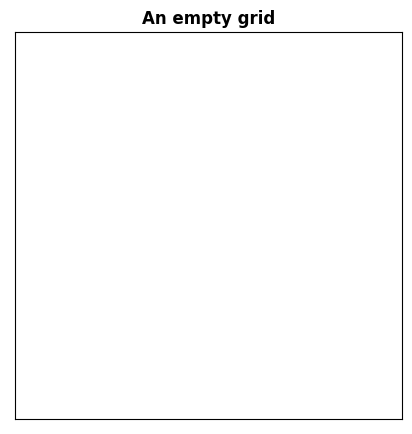

In [9]:
m=100
n=100
grid = [[[255,255,255] for i in range(0,m)] for i in range(0,n)] #the plt.imshow() function that we will use to visualize the grids, takes the value of each cell as the color of that cell
                                                                  #Colors here are represented as a list of 3 values of the Red,Green,Blue (RGB) spectrum with [255,255,255] being white.

plt.figure(figsize=(5,6), dpi= 100)
plt.imshow(grid)
plt.title('An empty grid',fontweight ="bold")
plt.yticks([]) #removes tick marks
plt.xticks([]) #removes tick marks
plt.show()

Now we will update the Individual class to allow each individual to reside in a specific location within this grid. We will also update the birth method to check for whether there are any adjacent empty positions available for a new cell. To check for empty squares, we introduce another class method called `vacant_cells`. This is a brute force method to check if the surrounding 8 squares of an individuals cell are empty or not.

In [10]:
class Individual:
    def __init__(self,growthrate,x,y,color):
        self.growthrate=growthrate
        self.x=x
        self.y=y
        
        self.color=color 
        
    def birth(self,grid):
        if random.choices([0,1], [1-self.growthrate,self.growthrate])[0]==1:
            empty_cells=self.vacant_cells(grid)
            if empty_cells==[]:
                pass
            else:
                daughter_x,daughter_y=random.choice(empty_cells)
                
                grid[daughter_x][daughter_y]=self.color
                return Individual(self.growthrate,x=daughter_x,y=daughter_y,color=self.color)
    
    def vacant_cells(self,grid): #check moore neighborhood (8 surrounding cells) for empty cells
        surroundings=[(-1,1),(0,1),(1,1),(-1,0),(1,0),(-1,-1),(0,-1),(1,-1)]
        empty_cells=[]
        for coords in surroundings:
            if grid[(self.x+coords[0])%len(grid)][(self.y+coords[1])%len(grid)] == [255,255,255]: 
                empty_cells.append(((self.x+coords[0])%len(grid),(self.y+coords[1])%len(grid)))
                
        if len(empty_cells)==0:
            self.growthrate=0      
        
        return empty_cells
      


We update the `Pop_Creator` function to assign a random x and y value to the initial cells and update the position of these cells within the grid.

In [11]:
def PopCreator(N0_size,grid):
    groupList=[]
    for j in range(0,N0_size):
        while True:

            x = random.choice(range(0,len(grid)))
            y = random.choice(range(0,len(grid)))
            
            color = list(np.random.choice(range(1,255), size=3)) #this creates a random RGB color
            
            if grid[x][y] == [255,255,255]:
                grid[x][y] = color
                groupList.append(Individual(growthrate=0.1,x=x,y=y,color=color))
                break
    return groupList


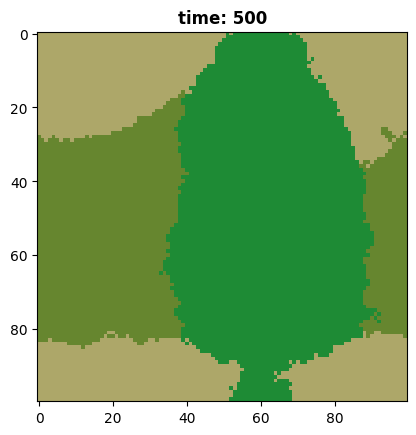

In [12]:
%matplotlib inline
from IPython.display import display, Markdown,clear_output

plt.figure(figsize=(5,6), dpi= 100)

n,m=100,100
grid = [[[255,255,255] for i in range(0,m)] for i in range(0,n)] 


Pop=PopCreator(N0_size=3,grid=grid)

output_pop=[]
for t in range(500):
    new_pop=[]
    for indiv in Pop:
        new_pop.append(indiv)
        new_indiv = indiv.birth(grid)
        if new_indiv != None:
            new_pop.append(new_indiv)
        
    output_pop.append(len(new_pop))
    Pop=new_pop
    

    clear_output(wait=True) #this command clears the previous plot allowing the automatic updating
    plt.imshow(grid,interpolation='None', animated=True)
    plt.title('time: '+str(t+1),fontweight ="bold")
    plt.show()


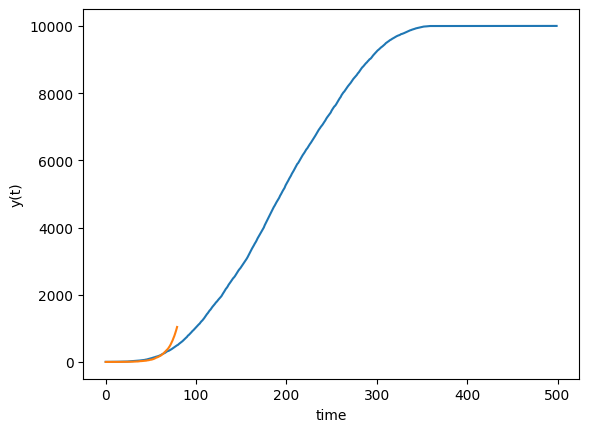

In [13]:
#Here the spatial component acts as a resource that is depleted resulting in a logistic curve. 
#However also the initial growth rate is slower in the spatial model as the effective population is limited to the edges of the growing clump.
plt.plot(range(len(output_pop)),output_pop)
plt.plot(range(len(output_pop_simple)),output_pop_simple)
plt.xlabel('time')
plt.ylabel('y(t)')
plt.show()

Let's include some obstacles in the environment. We do this by making some of the gridspace unavailable for growth.

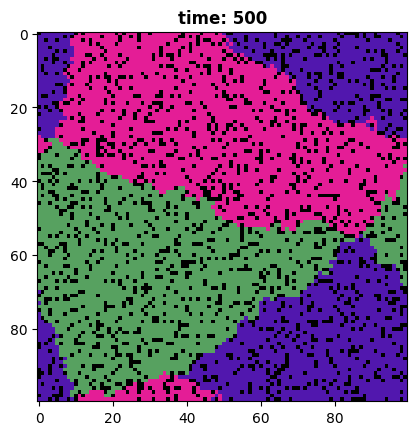

In [19]:
%matplotlib inline
from IPython.display import display, Markdown,clear_output
from matplotlib import colors

plt.figure(figsize=(5,6), dpi= 100)

grid = [[[255,255,255] for i in range(0,100)] for i in range(0,100)]
#add some black spots that are unavailable for growth
for n in range(2000):
    i,j=random.randrange(0, 100, 1),random.randrange(0, 100, 1)
    grid[i][j]=[0,0,0]  



Pop=PopCreator(N0_size=3,grid=grid)

output_pop_obst=[]
for t in range(500):
    new_pop=[]
    for indiv in Pop:
        new_pop.append(indiv)
        new_indiv = indiv.birth(grid)
        if new_indiv != None:
            new_pop.append(new_indiv)
        
    output_pop_obst.append(len(new_pop))
    Pop=new_pop
    

    clear_output(wait=True) #this command clears the previous plot allowing the automatic updating
    plt.imshow(grid,interpolation='None', animated=True)
    plt.title('time: '+str(t+1),fontweight ="bold")
    plt.show()



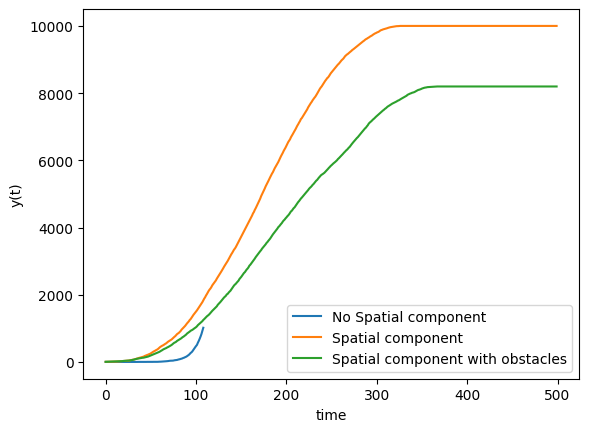

In [20]:
plt.plot(range(len(output_pop_simple)),output_pop_simple,label='No Spatial component')
plt.plot(range(len(output_pop)),output_pop,label='Spatial component')
plt.plot(range(len(output_pop_obst)),output_pop_obst,label='Spatial component with obstacles')
plt.xlabel('time')
plt.ylabel('y(t)')
plt.legend()
plt.show()

## Adding Mutation

In [21]:
class Individual:
    def __init__(self,growthrate,x,y,color):
        self.growthrate=growthrate
        self.x=x
        self.y=y

        self.color=color 
        
    def birth(self,grid):
        if random.choices([0,1], [1-self.growthrate,self.growthrate])[0]==1:
            empty_cells=self.vacant_cells(grid)
            if empty_cells==[]:
                pass
            else:
                daughter_x,daughter_y=random.choice(empty_cells)
                mutationrate=0.1
                if random.choices([0,1], [1-mutationrate,mutationrate])[0]==1:
                    Rand_color=list(np.random.choice(range(1,255), size=3)) 

                    grid[daughter_x][daughter_y]=Rand_color
                    return Individual(self.growthrate,x=daughter_x,y=daughter_y,color=Rand_color)
                else:
                    grid[daughter_x][daughter_y]=self.color
                    return Individual(self.growthrate,x=daughter_x,y=daughter_y,color=self.color)
    
                

    def vacant_cells(self,grid): #check moore neighborhood (8 surrounding cells) for empty cells
        surroundings=[(-1,1),(0,1),(1,1),(-1,0),(1,0),(-1,-1),(0,-1),(1,-1)]
        empty_cells=[]
        for coords in surroundings:
            if grid[(self.x+coords[0])%len(grid)][(self.y+coords[1])%len(grid)] == [255,255,255]: 
                empty_cells.append(((self.x+coords[0])%len(grid),(self.y+coords[1])%len(grid)))
                
        if len(empty_cells)==0:
            self.growthrate=0      
        
        return empty_cells
      

In [22]:
def PopCreator(N0_size,grid):
    groupList=[]
    for j in range(0,N0_size):
        while True:

            x = random.choice(range(0,len(grid)))
            y = random.choice(range(0,len(grid)))
            
            color = list(np.random.choice(range(1,255), size=3)) #this creates a random RGB color
            
            if grid[x][y] == [255,255,255]:
                grid[x][y] = color
                groupList.append(Individual(growthrate=0.1,x=x,y=y,color=color))
                break
    return groupList


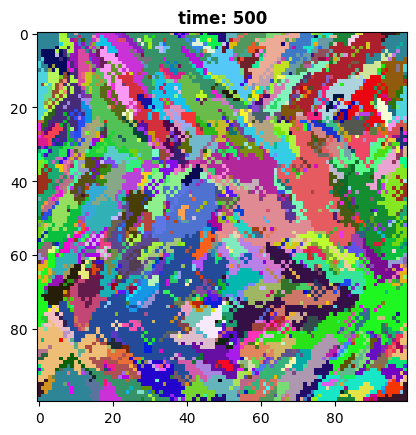

In [23]:
%matplotlib inline
from IPython.display import display, Markdown,clear_output

plt.figure(figsize=(5,6), dpi= 100)

n,m=100,100
grid = [[[255,255,255] for i in range(0,m)] for i in range(0,n)] 


Pop=PopCreator(N0_size=3,grid=grid)

output_pop=[]
for t in range(500):
    new_pop=[]
    for indiv in Pop:
        new_pop.append(indiv)
        new_indiv = indiv.birth(grid)
        if new_indiv != None:
            new_pop.append(new_indiv)
        
    output_pop.append(len(new_pop))
    Pop=new_pop
    

    clear_output(wait=True) #this command clears the previous plot allowing the automatic updating
    plt.imshow(grid,interpolation='None', animated=True)
    plt.title('time: '+str(t+1),fontweight ="bold")
    plt.show()


## Mutation of growth rate and selection 

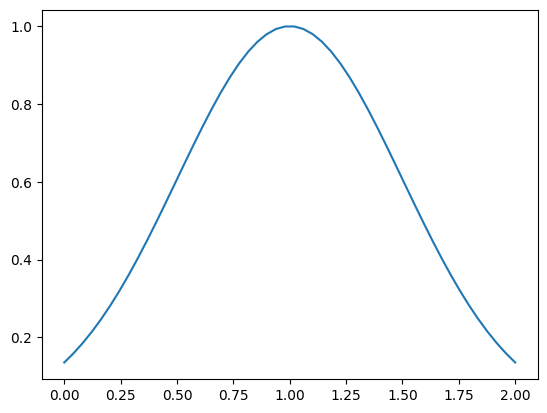

In [25]:
#Fitness function, convert growth rate to fitness between 0-1
out=[]
x=[]
for i in np.linspace(0,2):
    e=1
    z=i
    sigma=0.5
    fitness=np.exp(-((z-e)**2)/(2*sigma**2))
    out.append(fitness)
    x.append(i)
plt.plot(x,(out))

In [26]:
class Individual:
    def __init__(self,growthrate,x,y,color):
        self.growthrate=growthrate
        self.x=x
        self.y=y
        
        self.color=color 
        
    def birth(self,grid):
        e=1
        z=self.growthrate
        sigma=0.5
        fitness=np.exp(-((z-e)**2)/(2*sigma**2))
        if random.choices([0,1], [1-fitness,fitness])[0]==1:
            empty_cells=self.vacant_cells(grid)
            if empty_cells==[]:
                pass
            else:
                daughter_x,daughter_y=random.choice(empty_cells)
                mutationrate=0.01
                if random.choices([0,1], [1-mutationrate,mutationrate])[0]==1:
                    Rand_color=np.array(list(np.random.choice(range(1,255), size=3))) 

                    grid[daughter_x][daughter_y]=Rand_color
                    new_growthrate=np.random.normal(self.growthrate,0.1)
                    return Individual(new_growthrate,x=daughter_x,y=daughter_y,color=Rand_color)
                else:
                    grid[daughter_x][daughter_y]=self.color
                    return Individual(self.growthrate,x=daughter_x,y=daughter_y,color=self.color)
    
                

    def vacant_cells(self,grid): #check moore neighborhood (8 surrounding cells) for empty cells
        surroundings=[(-1,1),(0,1),(1,1),(-1,0),(1,0),(-1,-1),(0,-1),(1,-1)]
        empty_cells=[]
        for coords in surroundings:
            if all(grid[(self.x+coords[0])%len(grid)][(self.y+coords[1])%len(grid)] == np.array([255,255,255]))==True: 
                empty_cells.append(((self.x+coords[0])%len(grid),(self.y+coords[1])%len(grid)))
                
        if len(empty_cells)==0:
            self.growthrate=0      
        
        return empty_cells

In [27]:
def PopCreator(N0_size,grid):
    groupList=[]
    for j in range(0,N0_size):
        while True:

            x = random.choice(range(0,len(grid)))
            y = random.choice(range(0,len(grid)))
            
            color = np.array(list(np.random.choice(range(1,255), size=3))) #this creates a random RGB color
            
            if all(grid[x][y] == np.array([255,255,255]))==True:
                grid[x][y] = color
                groupList.append(Individual(growthrate=0.1,x=x,y=y,color=color))
                break
    return groupList


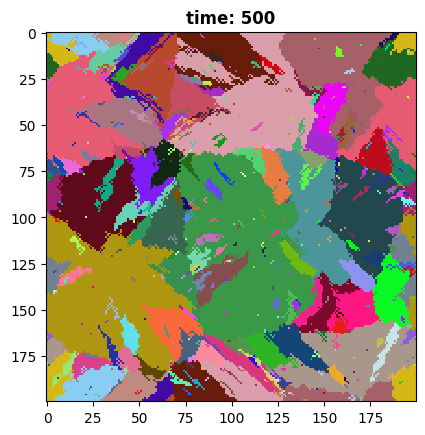

In [29]:
%matplotlib inline
from IPython.display import display, Markdown,clear_output

plt.figure(figsize=(5,6), dpi= 100)

n,m=200,200
grid = np.array([[[255,255,255] for i in range(0,m)] for i in range(0,n)]) 


Pop=PopCreator(N0_size=3,grid=grid)

output_pop=[]
for t in range(500):
    new_pop=[]
    for indiv in Pop:
        new_pop.append(indiv)
        new_indiv = indiv.birth(grid)
        if new_indiv != None:
            new_pop.append(new_indiv)
        
    output_pop.append(len(new_pop))
    
    new_pop2=[]
    for item in new_pop:
        if item.growthrate == 0:
            pass
        else:
            new_pop2.append(item) 
    new_pop=new_pop2
    Pop=new_pop
    

    clear_output(wait=True) #this command clears the previous plot allowing the automatic updating
    plt.imshow(grid,interpolation='None', animated=True)
    plt.title('time: '+str(t+1),fontweight ="bold")
    plt.show()

## Plate boundaries

In [20]:
class Individual:
    def __init__(self,growthrate,x,y,color,mutation_rate):
        self.growthrate=growthrate
        self.x=x
        self.y=y
        
        self.color=color 
        self.mutation_rate=mutation_rate
    def birth(self,grid):
        e=1
        z=self.growthrate
        sigma=0.5
        fitness=np.exp(-((z-e)**2)/(2*sigma**2))
        if random.choices([0,1], [1-fitness,fitness])[0]==1:
            empty_cells=self.vacant_cells(grid)
            if empty_cells==[]:
                pass
            else:
                daughter_x,daughter_y=random.choice(empty_cells)

                if random.choices([0,1], [1-self.mutation_rate,self.mutation_rate])[0]==1:
                    Rand_color=np.array(list(np.random.choice(range(1,255), size=3))) 

                    grid[daughter_x][daughter_y]=Rand_color
                    new_growthrate=np.random.normal(self.growthrate,0.1)
                    return Individual(new_growthrate,x=daughter_x,y=daughter_y,color=Rand_color,mutation_rate=self.mutation_rate)
                else:
                    grid[daughter_x][daughter_y]=self.color
                    return Individual(self.growthrate,x=daughter_x,y=daughter_y,color=self.color,mutation_rate=self.mutation_rate)
    
                

    def vacant_cells(self,grid): #check moore neighborhood (8 surrounding cells) for empty cells
        surroundings=[(-1,1),(0,1),(1,1),(-1,0),(1,0),(-1,-1),(0,-1),(1,-1)]
        empty_cells=[]
        for coords in surroundings:
            if (0<(self.x+coords[0]) < len(grid)) and  (0<(self.y+coords[1]) < len(grid[0])):
                if all(grid[(self.x+coords[0])][(self.y+coords[1])] == np.array([255,255,255]))==True: 
                    empty_cells.append(((self.x+coords[0]),(self.y+coords[1])))
                
        if len(empty_cells)==0:
            self.growthrate=0      
        
        return empty_cells

In [21]:
def PopCreator(N0_size,grid,mutation_r):
    groupList=[]
    for j in range(0,N0_size):
        while True:

            x = np.linspace(1, len(grid)-1, N0_size, dtype='int')[j]#random.choice(range(0,len(grid)))
            y = 0
            
            color = np.array(list(np.random.choice(range(1,255), size=3))) #this creates a random RGB color
            
            if all(grid[x][y] == np.array([255,255,255]))==True:
                grid[x][y] = color
                groupList.append(Individual(growthrate=0.1,x=x,y=y,color=color,mutation_rate=mutation_r))
                break
    return groupList


In [33]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
from IPython.display import display, Markdown,clear_output

def simulate():
    plt.figure(figsize=(20,10), dpi= 50)

    m=100
    n=400
    grid = np.array([[[255,255,255] for i in range(0,n)] for i in range(0,m)]) 


    Pop=PopCreator(N0_size=10,grid=grid,mutation_r=0.01)

    output_pop=[]
    while True:
        new_pop=[]
        for indiv in Pop:
            new_pop.append(indiv)
            new_indiv = indiv.birth(grid)
            if new_indiv != None:
                new_pop.append(new_indiv)

        output_pop.append(len(new_pop))

        new_pop2=[]
        for item in new_pop:
            if item.growthrate == 0:
                pass
            else:
                new_pop2.append(item) 
        new_pop=new_pop2
        Pop=new_pop


        clear_output(wait=True) #this command clears the previous plot allowing the automatic updatin
        plt.imshow(grid,interpolation='None', animated=True)
        plt.title('time: '+str(t+1)+ ' Average Growth rate: '+str(np.average([indiv.growthrate for indiv in Pop])),fontweight ="bold")
        plt.show()

        if Pop ==[]:
            break

In [34]:
simulate()

KeyboardInterrupt: 

In [30]:
from IPython.display import display, Markdown,HTML
display(Markdown("#### Evolution of Bacteria on a “Mega-Plate” Petri Dish (Kishony Lab)"))
HTML('<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/plVk4NVIUh8" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

#### Evolution of Bacteria on a “Mega-Plate” Petri Dish (Kishony Lab)

C:\Program Files\Python38\lib\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


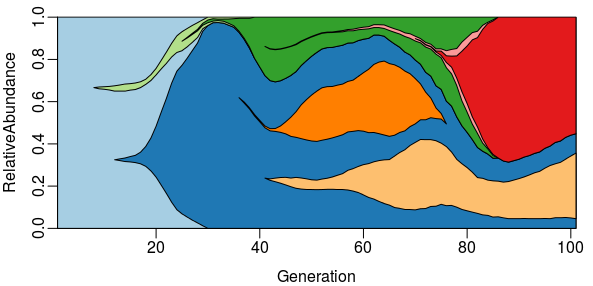
https://en.wikipedia.org/wiki/Muller_plot

In [ ]:
len(grid),len(grid[0])

## Speed Optimization and adding an obstacle
Increase run speed using Numba, Cython or Pypy.  
https://numba.pydata.org/numba-doc/dev/index.html  
https://cython.org/  
https://www.pypy.org/features.html 

In [28]:
from numba import jit

In [29]:
class Individual:
    def __init__(self,growthrate,x,y,color,mutation_rate):
        self.growthrate=growthrate
        self.x=x
        self.y=y
        
        self.color=color 
        self.mutation_rate=mutation_rate
    def birth(self,grid):
        e=1
        z=self.growthrate
        sigma=0.5
        fitness=np.exp(-((z-e)**2)/(2*sigma**2))
        if random.choices([0,1], [1-fitness,fitness])[0]==1:
            empty_cells=self.vacant_cells(self.x,self.y,grid)
            if empty_cells==[]:
                pass
            else:
                daughter_x,daughter_y=random.choice(empty_cells)

                if random.choices([0,1], [1-self.mutation_rate,self.mutation_rate])[0]==1:
                    Rand_color=np.array(list(np.random.choice(range(1,255), size=3))) 

                    grid[daughter_x][daughter_y]=Rand_color
                    new_growthrate=np.random.normal(self.growthrate,0.1)
                    #new_growthrate=self.growthrate
                    return Individual(new_growthrate,x=daughter_x,y=daughter_y,color=Rand_color,mutation_rate=self.mutation_rate)
                else:
                    grid[daughter_x][daughter_y]=self.color
                    return Individual(self.growthrate,x=daughter_x,y=daughter_y,color=self.color,mutation_rate=self.mutation_rate)
    
                
    @staticmethod
    @jit(nopython=True)  
    def vacant_cells(x,y,grid): #check moore neighborhood (8 surrounding cells) for empty cells
        surroundings=[(-1,1),(0,1),(1,1),(-1,0),(1,0),(-1,-1),(0,-1),(1,-1)]
        empty_cells=[]
        for coords in surroundings:
            if (0<(x+coords[0]) < len(grid)) and  (0<(y+coords[1]) < len(grid[0])):
                if list(grid[(x+coords[0])][(y+coords[1])]) == [255,255,255]: 
                    empty_cells.append(((x+coords[0]),(y+coords[1])))
                   
        
        return empty_cells

In [30]:
def PopCreator(N0_size,grid,mutation_r):
    groupList=[]
    for j in range(0,N0_size):
        while True:

            x = np.linspace(1, len(grid)-1, N0_size, dtype='int')[j]#random.choice(range(0,len(grid)))
            y = 0
            
            color = np.array(list(np.random.choice(range(1,255), size=3))) #this creates a random RGB color
            
            if all(grid[x][y] == np.array([255,255,255]))==True:
                grid[x][y] = color
                groupList.append(Individual(growthrate=0.2,x=x,y=y,color=color,mutation_rate=mutation_r))
                break
    return groupList


In [31]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
from IPython.display import display, Markdown,clear_output

def simulate():
    plt.figure(figsize=(20,10), dpi= 50)

    m=100
    n=400
    grid = np.array([[[255,255,255] for i in range(0,n)] for i in range(0,m)]) 
    for j,i in zip(np.full((100, 1), 100),np.linspace(0,49,num=50,dtype=int)):
        grid[i][j]=[0,0,0]  
    for j,i in zip(np.full((100, 1), 100),np.linspace(51,99,num=49,dtype=int)):
        grid[i][j]=[0,0,0]  
        
    for j,i in zip(np.full((100, 1), 101),np.linspace(0,49,num=50,dtype=int)):
        grid[i][j]=[0,0,0]  
    for j,i in zip(np.full((100, 1), 101),np.linspace(51,99,num=49,dtype=int)):
        grid[i][j]=[0,0,0]  

    Pop=PopCreator(N0_size=10,grid=grid,mutation_r=0.005)

    output_pop=[]
    t=0
    while True:
        new_pop=[]
        for indiv in Pop:
            new_pop.append(indiv)
            new_indiv = indiv.birth(grid)
            if new_indiv != None:
                new_pop.append(new_indiv)

        output_pop.append(len(new_pop))

        new_pop2=[]
        for item in new_pop:
            if item.growthrate == 0:
                pass
            else:
                new_pop2.append(item) 
        new_pop=new_pop2
        Pop=new_pop

        #clear_output(wait=True)
        #plt.matshow(grid, interpolation="none")
        #plt.yticks([]) 
        #plt.xticks([]) 
        #plt.title('time: '+str(t+1),fontweight ="bold")
        #plt.pause(0.01)
     
        t+=1
        if t == 500:
            plt.matshow(grid, interpolation="none")
            plt.yticks([]) 
            plt.xticks([]) 
            plt.title('time: '+str(t+1),fontweight ="bold")
            break

<Figure size 1000x500 with 0 Axes>

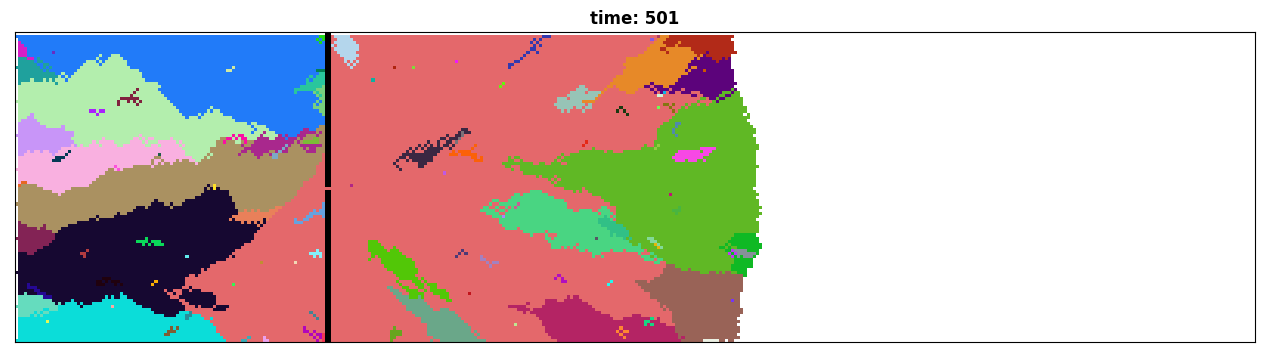

In [32]:
simulate()

In [ ]:
%timeit simulate()

In [ ]:
%timeit simulate()

In [ ]:
np.linspace(0,99,num=100,dtype=int)

In [ ]:
grid[200]

In [ ]:
k